In [0]:
import nltk

In [2]:
nltk.download_shell()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> 1
Command '1' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
from datetime import date
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#List to keep different methods scores to compare
ScoreSummaryByMethod=[]

In [0]:
# Loading Data
df = pd.read_csv("/content/drive/My Drive/NLP/Combined_News_DJIA.csv")

In [12]:
df.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


In [0]:
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

In [14]:
df.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Combined
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""","['b""Georgia \'downs two Russian warplanes\' as..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...","[""b'Why wont America and Nato help us? If they..."


In [15]:
pd.to_datetime(df["Date"])

0      2008-08-08
1      2008-08-11
2      2008-08-12
3      2008-08-13
4      2008-08-14
          ...    
1984   2016-06-27
1985   2016-06-28
1986   2016-06-29
1987   2016-06-30
1988   2016-07-01
Name: Date, Length: 1989, dtype: datetime64[ns]

In [16]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined']]
print(train.shape)
print(train.head(2))


(1611, 2)
   Label                                           Combined
0      0  ['b"Georgia \'downs two Russian warplanes\' as...
1      1  ["b'Why wont America and Nato help us? If they...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [17]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined']]
test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined
1611,1,['Most cases of cancer are the result of sheer...
1612,0,['Moscow-&gt;Beijing high speed train will red...
1613,0,"['US oil falls below $50 a barrel'\n ""Toyota g..."
1614,1,"[""'Shots fired' at French magazine HQ""\n '90% ..."
1615,1,['New Charlie Hebdo issue to come out next wee...


In [18]:
df['Combined'][3]

'["b\' U.S. refuses Israel weapons to attack Iran: report\'"\n \'b"When the president ordered to attack Tskhinvali [the capital of South Ossetia], we knew then we were doomed. How come he didn\\\'t realize that?"\'\n "b\' Israel clears troops who killed Reuters cameraman\'"\n \'b\\\'Britain\\\\\\\'s policy of being tough on drugs is "pointless", says a former civil servant who once ran the Cabinet\\\\\\\'s anti-drugs unit.\\\'\'\n "b\'Body of 14 year old found in trunk; Latest (ransom paid) kidnapping victim in Mexico. Head cop quits, Prez dissolves suspect elite task force\'"\n "b\'China has moved 10 *million* quake survivors into prefab homes\'"\n \'b"Bush announces Operation Get All Up In Russia\\\'s Grill. Yeah, this will end well."\'\n "b\'Russian forces sink Georgian ships \'"\n \'b"The commander of a Navy air reconnaissance squadron that provides the President and the defense secretary the airborne ability to command the nation\\\'s nuclear weapons has been relieved of duty"\'\n

In [0]:
text = '["b\' U.S. refuses Israel weapons to attack Iran: report\'"\n \'b"When the president ordered to attack Tskhinvali [the capital of South Ossetia], we knew then we were doomed. How come he didn\\\'t realize that?"\'\n "b\' Israel clears troops who killed Reuters cameraman\'"\n \'b\\\'Britain\\\\\\\'s policy of being tough on drugs is "pointless", says a former civil servant who once ran the Cabinet\\\\\\\'s anti-drugs unit.\\\'\'\n "b\'Body of 14 year old found in trunk; Latest (ransom paid) kidnapping victim in Mexico. Head cop quits, Prez dissolves suspect elite task force\'"\n "b\'China has moved 10 *million* quake survivors into prefab homes\'"\n \'b"Bush announces Operation Get All Up In Russia\\\'s Grill. Yeah, this will end well."\'\n "b\'Russian forces sink Georgian ships \'"\n \'b"The commander of a Navy air reconnaissance squadron that provides the President and the defense secretary the airborne ability to command the nation\\\'s nuclear weapons has been relieved of duty"\'\n \'b"92% of CNN readers: Russia\\\'s actions in Georgia - justified!"\'\n \'b\\\'USA to send fleet into Black Sea to help Georgia, send troops in "humanitarian aid exercise"\\\'\'\n \'b"US warns against Israeli plan to strike against Iran\\\'s nuclear facilities"\'\n \'b"In an intriguing cyberalliance, two Estonian computer experts are heading to Georgia to keep the country\\\'s networks running amid an intense military confrontation with Russia"\'\n "b\'The CNN Effect: Georgia Schools Russia in Information Warfare\'"\n "b\'Why Russias response to Georgia was right\'"\n "b\'Elephants extinct by 2020?\'"\n "b\'US humanitarian missions soon in Georgia - if Russia hits the US - WWIII?\'"\n \'b"Georgia\\\'s DDOS came from US sources"\'\n "b\'Russian convoy heads into Georgia, violating truce\'"\n "b\'Israeli defence minister: US against strike on Iran\'"\n "b\'Gorbachev: We Had No Choice\'"\n "b\'Witness: Russian forces head towards Tbilisi in breach of ceasefire agreement\'"\n "b\' Quarter of Russians blame U.S. for conflict: poll\'"\n "b\'Georgian president  says US military will take control of seaports and airports - Pentagon denies\'"\n "b\'2006: Nobel laureate Aleksander Solzhenitsyn accuses U.S., NATO of encircling Russia\'"]'

In [20]:
tokenizer = RegexpTokenizer(r'\w+') ## any non word character excluding [a-zA-Z0-9]
text_processed=tokenizer.tokenize(text)
' '.join(text_processed)

'b U S refuses Israel weapons to attack Iran report b When the president ordered to attack Tskhinvali the capital of South Ossetia we knew then we were doomed How come he didn t realize that b Israel clears troops who killed Reuters cameraman b Britain s policy of being tough on drugs is pointless says a former civil servant who once ran the Cabinet s anti drugs unit b Body of 14 year old found in trunk Latest ransom paid kidnapping victim in Mexico Head cop quits Prez dissolves suspect elite task force b China has moved 10 million quake survivors into prefab homes b Bush announces Operation Get All Up In Russia s Grill Yeah this will end well b Russian forces sink Georgian ships b The commander of a Navy air reconnaissance squadron that provides the President and the defense secretary the airborne ability to command the nation s nuclear weapons has been relieved of duty b 92 of CNN readers Russia s actions in Georgia justified b USA to send fleet into Black Sea to help Georgia send tr

In [21]:
len(' '.join(text_processed))

1972

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
# removing any stopwords
text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
' '.join(text_processed)

'b u refuses israel weapons attack iran report b president ordered attack tskhinvali capital south ossetia knew doomed come realize b israel clears troops killed reuters cameraman b britain policy tough drugs pointless says former civil servant ran cabinet anti drugs unit b body 14 year old found trunk latest ransom paid kidnapping victim mexico head cop quits prez dissolves suspect elite task force b china moved 10 million quake survivors prefab homes b bush announces operation get russia grill yeah end well b russian forces sink georgian ships b commander navy air reconnaissance squadron provides president defense secretary airborne ability command nation nuclear weapons relieved duty b 92 cnn readers russia actions georgia justified b usa send fleet black sea help georgia send troops humanitarian aid exercise b us warns israeli plan strike iran nuclear facilities b intriguing cyberalliance two estonian computer experts heading georgia keep country networks running amid intense milit

In [26]:
len(' '.join(text_processed))

1615

In [0]:
porter_stemmer = PorterStemmer()    
text_processed = [porter_stemmer.stem(word) for word in text_processed]

In [28]:
' '.join(text_processed)

'b u refus israel weapon attack iran report b presid order attack tskhinvali capit south ossetia knew doom come realiz b israel clear troop kill reuter cameraman b britain polici tough drug pointless say former civil servant ran cabinet anti drug unit b bodi 14 year old found trunk latest ransom paid kidnap victim mexico head cop quit prez dissolv suspect elit task forc b china move 10 million quak survivor prefab home b bush announc oper get russia grill yeah end well b russian forc sink georgian ship b command navi air reconnaiss squadron provid presid defens secretari airborn abil command nation nuclear weapon reliev duti b 92 cnn reader russia action georgia justifi b usa send fleet black sea help georgia send troop humanitarian aid exercis b us warn isra plan strike iran nuclear facil b intrigu cyberalli two estonian comput expert head georgia keep countri network run amid intens militari confront russia b cnn effect georgia school russia inform warfar b russia respons georgia rig

In [29]:
len(' '.join(text_processed))

1459

In [30]:
df.shape

(1989, 28)

In [0]:
#Text pre-processing

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+') ## any non word character excluding [a-zA-Z0-9]
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming 
    '''
    stemming is a sort of normalizing method. Many variations of words carry the same meaning, other than when tense is involved.
    '''
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed
    

In [0]:
#Creating a Data Pipeline for Bernoulli Naive Bayes classifier classifier and n-grams, default alpha=1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB(binarize=0.0)),  # train on TF-IDF vectors w/ Bernoulli Naive Bayes classifier
])


In [0]:
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])

In [0]:
def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [0]:
def heatmap(data, rotate_xticks=True):
  fig, ax = plt.subplots()
  heatmap = sns.heatmap(data, cmap=plt.cm.Blues)
  ax.xaxis.tick_top()
  if rotate_xticks:
      plt.xticks(rotation=90)
  plt.yticks(rotation=0)

In [0]:
def plot_classification_report(classification_report):
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)
    aveTotal = lines[len(lines) - 1].split()
    classes.append('avg/total')
    vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
    plotMat.append(vAveTotal)
    df_classification_report = DataFrame(plotMat, index=classes,columns=['precision', 'recall', 'f1-score'])
    heatmap(df_classification_report)

In [0]:
def plot_confusion_matrix(confusion_matrix,classes=['0','1']):
    df_confusion_matrix = DataFrame(confusion_matrix, index=classes,columns=classes)
    heatmap(df_confusion_matrix,False)

In [0]:
def Evaluation (Method,Comment,Actual, Predicted):
    '''
        Prints and plots
        - classification report
        - confusion matrix
        - ROC-AUC
    '''
    print (Method)
    print (Comment)
    print (classification_report(Actual,Predicted))
    #plot_classification_report(classification_report(Actual,Predicted))
    print ('Confussion matrix:\n', confusion_matrix(Actual,Predicted))
    #plot_confusion_matrix(confusion_matrix(Actual,Predicted))
    ROC_AUC=roc_auc_score(Actual,Predicted)
    print ('ROC-AUC: ' + str(ROC_AUC))
    #ROCCurves (Actual,Predicted)
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)
    ScoreSummaryByMethod.append([Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1])

In [41]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
nb_pipeline.fit(train['Combined'],train['Label'])
predictions = nb_pipeline.predict(test['Combined'])
Evaluation ('MultinomialNB','no shift, no n-grams, combined Top news',test["Label"], predictions)

MultinomialNB
no shift, no n-grams, combined Top news
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378

Confussion matrix:
 [[  0 186]
 [  0 192]]
ROC-AUC: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
Evaluation ('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(binarize=0.0)
default alpha=1,no shift, ngram_range=(1, 2), combined Top news
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       186
           1       0.51      1.00      0.67       192

    accuracy                           0.51       378
   macro avg       0.25      0.50      0.34       378
weighted avg       0.26      0.51      0.34       378

Confussion matrix:
 [[  0 186]
 [  0 192]]
ROC-AUC: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#1 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [44]:
#new train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined']]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined
0,1.0,"['b""Georgia \'downs two Russian warplanes\' as..."
1,0.0,"[""b'Why wont America and Nato help us? If they..."
2,0.0,"[""b'Remember that adorable 9-year-old who sang..."
3,1.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1.0,"[""b'All the experts admit that we should legal..."


In [52]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 1-day shift is smoothing alpha = 0 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.0, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(alpha=0.0,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


BernoulliNB(alpha=0.0,binarize=0.0)
1-day shift, ngram_range=(1, 2), combined Top news
              precision    recall  f1-score   support

         0.0       0.58      0.44      0.50       184
         1.0       0.56      0.69      0.62       191

    accuracy                           0.57       375
   macro avg       0.57      0.57      0.56       375
weighted avg       0.57      0.57      0.56       375

Confussion matrix:
 [[ 81 103]
 [ 59 132]]
ROC-AUC: 0.5656584338720692


In [0]:
#3 days shift
df.Label = df.Label.shift(-2)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)

In [54]:
#new train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined']]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined
0,1.0,"['b""Georgia \'downs two Russian warplanes\' as..."
1,0.0,"[""b'Why wont America and Nato help us? If they..."
2,0.0,"[""b'Remember that adorable 9-year-old who sang..."
3,1.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1.0,"[""b'All the experts admit that we should legal..."


In [55]:
#new test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined']]
test.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined
1979,0.0,['A staggering 87 percent of Venezuelans say t...
1980,1.0,['An Australian athlete who has competed in si...
1981,1.0,['German government agrees to ban fracking ind...
1982,1.0,['Today The United Kingdom decides whether to ...
1983,1.0,['David Cameron to Resign as PM After EU Refer...


In [56]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 3-day shift is smoothing alpha = 0.5 
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2), combined Top news
              precision    recall  f1-score   support

         0.0       0.49      0.40      0.44       184
         1.0       0.50      0.59      0.55       189

    accuracy                           0.50       373
   macro avg       0.50      0.50      0.49       373
weighted avg       0.50      0.50      0.49       373

Confussion matrix:
 [[ 74 110]
 [ 77 112]]
ROC-AUC: 0.4973832528180354


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


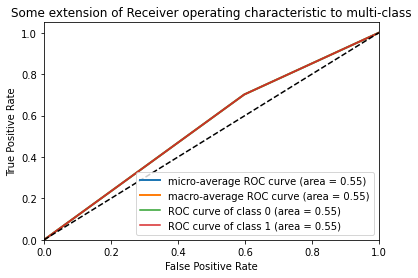

In [50]:
ROCCurves (test["Label"], predictions)

In [0]:
#Here is the pipeline we use for the differenet data sets
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])

In [0]:
#data re-new
df=pd.read_csv('/content/drive/My Drive/NLP/Combined_News_DJIA.csv')

In [0]:
#Combination 10 and 25
df['Combined10_25']=df.iloc[:,[11,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
#Combination 12 and 25
df['Combined12_25']=df.iloc[:,[13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)#Combination 10 and 25
df['Combined10_25']=df.iloc[:,[11,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
#Combination 12 and 25
df['Combined12_25']=df.iloc[:,[13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [62]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Top1','Top12','Top25','Combined10_25','Combined12_25','Combined3_12_25']]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,Label,Top1,Top12,Top25,Combined10_25,Combined12_25,Combined3_12_25
0,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'Announcing:Class Action Lawsuit on Behalf of...,"b""No Help for Mexico's Kidnapping Surge""","[""b'Did the U.S. Prep Georgia for War with Rus...","[""b'Announcing:Class Action Lawsuit on Behalf ...",NaN
1,1,b'Why wont America and Nato help us? If they w...,b'Abhinav Bindra wins first ever Individual Ol...,"b""So this is what it's come to: trading sex fo...","['b""Georgia\'s move, a mistake of monumental p...","[""b'Abhinav Bindra wins first ever Individual ...",NaN
2,0,b'Remember that adorable 9-year-old who sang a...,b'CNN use footage of Tskhinvali ruins to cover...,"b""BBC NEWS | Asia-Pacific | Extinction 'by man...","[""b'U.S. Beats War Drum as Iran Dumps the Doll...","[""b'CNN use footage of Tskhinvali ruins to cov...",NaN
3,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""US warns against Israeli plan to strike agai...",b'2006: Nobel laureate Aleksander Solzhenitsyn...,"['b""92% of CNN readers: Russia\'s actions in G...","['b""US warns against Israeli plan to strike ag...",NaN
4,1,b'All the experts admit that we should legalis...,b'Why Russias response to Georgia was right',b'Philippines : Peace Advocate say Muslims nee...,"[""b' Musharraf expected to resign rather than ...","[""b'Why Russias response to Georgia was right'...",NaN


In [63]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Top1','Top12','Top25','Combined10_25','Combined12_25','Combined3_12_25']]
test.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,Label,Top1,Top12,Top25,Combined10_25,Combined12_25,Combined3_12_25
1984,0,Barclays and RBS shares suspended from trading...,Sky News Journalist Left Speechless As Leave M...,Pakistani clerics declare transgender marriage...,['Angela Merkel said the U.K. must file exit p...,"[""Sky News Journalist Left Speechless As Leave...",NaN
1985,1,"2,500 Scientists To Australia: If You Want To ...","Merkel vows to strengthen EU, tells UK no 'che...",Mexico's security forces routinely use 'sexual...,"[""'Do not let Scotland down now' : Scottish ME...","[""Merkel vows to strengthen EU, tells UK no 'c...",NaN
1986,1,Explosion At Airport In Istanbul,The Philippine president-elect said Monday he ...,Tiny New Zealand town with 'too many jobs' lau...,['99-Million-Yr-Old Bird Wings Found Encased i...,['The Philippine president-elect said Monday h...,NaN
1987,1,Jamaica proposes marijuana dispensers for tour...,Cannabis compounds could treat Alzheimer's by ...,Law Enforcement Sources: Gun Used in Paris Ter...,['US airstrikes kill at least 250 ISIS fighter...,"[""Cannabis compounds could treat Alzheimer's b...",NaN
1988,1,A 117-year-old woman in Mexico City finally re...,Abbas PLO Faction Calls Killer of 13-Year-Old ...,Ozone layer hole seems to be healing - US &amp...,['China kills millions of innocent meditators ...,['Abbas PLO Faction Calls Killer of 13-Year-Ol...,NaN


In [64]:
#no changes in the pipeline. We just use other data sets
#Top1, no shift, baseline
bnb_2ngram_pipeline.fit(train['Top1'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Top1'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Top1 only',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Top1 only
              precision    recall  f1-score   support

           0       0.50      0.41      0.45       186
           1       0.52      0.61      0.56       192

    accuracy                           0.51       378
   macro avg       0.51      0.51      0.50       378
weighted avg       0.51      0.51      0.51       378

Confussion matrix:
 [[ 76 110]
 [ 75 117]]
ROC-AUC: 0.5089885752688172


In [0]:
#no changes in the pipeline. We just use other data sets
#Top25, no shift
bnb_2ngram_pipeline.fit(train['Top25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Top25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Top25 only',test["Label"], predictions)

In [66]:
#no changes in the pipeline. We just use other data sets
#Combined12_25, no shift
bnb_2ngram_pipeline.fit(train['Combined12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Combined Top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Combined Top12 and Top25
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       186
           1       0.57      0.66      0.61       192

    accuracy                           0.57       378
   macro avg       0.58      0.57      0.57       378
weighted avg       0.57      0.57      0.57       378

Confussion matrix:
 [[ 90  96]
 [ 65 127]]
ROC-AUC: 0.5726646505376345


In [67]:
#no changes in the pipeline. We just use other data sets
#Combined10_25, no shift
bnb_2ngram_pipeline.fit(train['Combined10_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined10_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','no shift, ngram_range=(1, 2),Combined Top10 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
no shift, ngram_range=(1, 2),Combined Top10 and Top25
              precision    recall  f1-score   support

           0       0.61      0.45      0.52       186
           1       0.58      0.73      0.64       192

    accuracy                           0.59       378
   macro avg       0.60      0.59      0.58       378
weighted avg       0.60      0.59      0.58       378

Confussion matrix:
 [[ 83 103]
 [ 52 140]]
ROC-AUC: 0.5877016129032258


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


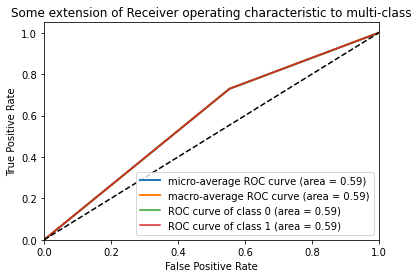

In [68]:
ROCCurves (test["Label"], predictions)

In [0]:
#let's shift the data and explore Top3, Top12 and Top25 combination for 2 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [0]:
#Combination 3,12 and 25
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [71]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined3_12_25']]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined3_12_25
0,0.0,"[""b'Russia Today: Columns of troops roll into ..."
1,0.0,"['b""Jewish Georgian minister: Thanks to Israel..."
2,1.0,"['b\'""If we had no sexual harassment we would ..."
3,1.0,"[""b' Israel clears troops who killed Reuters c..."
4,0.0,"[""b'Swedish wrestler Ara Abrahamian throws awa..."


In [72]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined3_12_25']]
test.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined3_12_25
1982,0.0,['Report: China is still harvesting organs fro...
1983,1.0,['Nicola Sturgeon says a second independence r...
1984,1.0,"[""Poland 'shocked' by xenophobic abuse of Pole..."
1985,1.0,"[""S&amp;P cuts United Kingdom sovereign credit..."
1986,1.0,['UK must accept freedom of movement to access...


In [73]:
#no changes in the pipeline. We just use other data sets
#Combined Top3, Top12 and Top25, 3-days shift
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
              precision    recall  f1-score   support

         0.0       0.61      0.50      0.55       185
         1.0       0.58      0.69      0.63       191

    accuracy                           0.59       376
   macro avg       0.60      0.59      0.59       376
weighted avg       0.59      0.59      0.59       376

Confussion matrix:
 [[ 92  93]
 [ 60 131]]
ROC-AUC: 0.5915805858214235


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


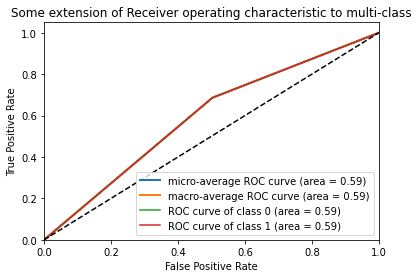

In [74]:
ROCCurves (test["Label"], predictions)

In [0]:
#let's shift the data and explore Top1 and Top6 combination for 3 days shift
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)

In [0]:
#Combination 1 and 6
df['Combined1_6']=df.iloc[:,[2,7]].apply(lambda row: ''.join(str(row.values)), axis=1)

In [84]:
#train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Combined1_6']]
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined1_6
0,1.0,"['b""Georgia \'downs two Russian warplanes\' as..."
1,1.0,"[""b'Why wont America and Nato help us? If they..."
2,0.0,"[""b'Remember that adorable 9-year-old who sang..."
3,0.0,"[""b' U.S. refuses Israel weapons to attack Ira..."
4,1.0,"[""b'All the experts admit that we should legal..."


In [85]:
#test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Combined1_6']]
test.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


,Label,Combined1_6
1980,0.0,['An Australian athlete who has competed in si...
1981,1.0,['German government agrees to ban fracking ind...
1982,1.0,['Today The United Kingdom decides whether to ...
1983,1.0,['David Cameron to Resign as PM After EU Refer...
1984,1.0,['Barclays and RBS shares suspended from tradi...


In [86]:
#no changes in the pipeline. We just use other data sets
#Combined Top1 and Top6, 3-days shift
bnb_2ngram_pipeline.fit(train['Combined1_6'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined1_6'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2),Combined Top1 and Top6',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2),Combined Top1 and Top6
              precision    recall  f1-score   support

         0.0       0.49      0.41      0.45       184
         1.0       0.51      0.59      0.55       190

    accuracy                           0.50       374
   macro avg       0.50      0.50      0.50       374
weighted avg       0.50      0.50      0.50       374

Confussion matrix:
 [[ 75 109]
 [ 77 113]]
ROC-AUC: 0.5011727688787185


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


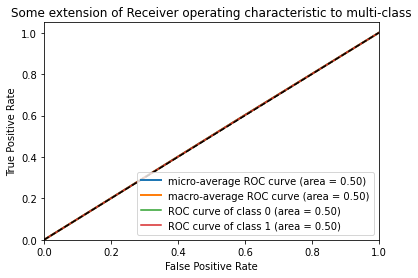

In [87]:
ROCCurves (test["Label"], predictions)

In [88]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_ScoreSummaryByMethod.head(20) 

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
10,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.591581,0.584821,0.593085,0.685864,0.631325
9,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Combined Top10 an...",0.587702,0.576132,0.589947,0.729167,0.643678
8,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Combined Top12 an...",0.572665,0.569507,0.574074,0.661458,0.612048
5,"BernoulliNB(alpha=0.0,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.565658,0.561702,0.568000,0.691099,0.619718
11,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2),Combined Top1...",0.560124,0.556485,0.562667,0.696335,0.618605
4,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.551872,0.549180,0.554667,0.701571,0.616092
7,"BernoulliNB(alpha=0.5,binarize=0.0)","no shift, ngram_range=(1, 2),Top1 only",0.508989,0.515419,0.510582,0.609375,0.558473
3,"BernoulliNB(alpha=0.0,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.504704,0.511278,0.507937,0.708333,0.593886
12,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2),Combined Top1...",0.501173,0.509009,0.502674,0.594737,0.548544
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.507937,0.507937,1.000000,0.673684
